# Exploring the Titanic Dataset (Python version)
Anton Fefilov
2 november 2016

## 1 Introduction
This is my second attempt to make ML research myself after awesome Andrew Ng's Coursera course on Machine Learning. As a basis for the first attempt I took the awesome kernel [Exploring the Titanic Dataset](https://www.kaggle.com/mrisdal/titanic/exploring-survival-on-the-titanic) authored by Megan Risdal and reworked it with Python. Also I took a lot of useful information for this work in [A Journey through Titanic](https://www.kaggle.com/omarelgabry/titanic/a-journey-through-titanic) kernel by Omar El Gabry. Unexpectedly my experiment has been failed: after finishing and submitting results to the Kaggle I was scored with 0. One of the possible variants to continue investigations is to try to figure out what's wrong with my calculations, but I don't want to go this way. And that is why.
As I followed Megan's flow while trying to solve Titanic's challenge, work has been divided into three parts:

*    Feature engineering
*    Missing value imputation
*    Prediction!

But I strongly feel I should start with prediction in the simplest form, evaluate it and submit results to the Kaggle in order to understand how succesfull my prediction is. After this I should engineer any new features and reiterate the process above and after every iteration I will see if feature engineering bring any impact.

### 1.1 Load and check data

In [48]:
# Load packages

# pandas
import pandas as pd
from pandas import Series, DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
import seaborn as sns

# configure seaborn
sns.set_style('whitegrid')

# draw graphics inline
%matplotlib inline

# machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from patsy import dmatrices

Now that our packages are loaded, let’s read in and take a peek at the data.

In [49]:
# get titanic & test csv files as a DataFrame
train_df = pd.read_csv("input/train.csv")
test_df = pd.read_csv("input/test.csv")

# add dummy Survived variable to the test set in order to use patsy's formulas
test_df['Survived'] = 0.5

In [50]:
# preview the train data structure
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [51]:
# get sense of variables and datatypes
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [52]:
# and the same steps for the test data structure
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.5
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0.5
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0.5
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0.5
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0.5


In [53]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
Survived       418 non-null float64
dtypes: float64(3), int64(4), object(5)
memory usage: 39.3+ KB


We’ve got a sense of our variables, their class type, and the first few observations of each. We know we’re working with 1309 observations of 12 variables. To make things a bit more explicit since a couple of the variable names aren’t 100% illuminating, here’s what we’ve got to deal with:

| Variable Name | Description |
| --- | --- |
| PassengerId | Passenger's id |
| Survived | Survived (1) or died (0) |
| Pclass | Passenger’s class |
| Name | Passenger’s name |
| Sex | Passenger’s sex |
| Age | Passenger’s age |
| SibSp | Number of siblings/spouses aboard |
| Parch | Number of parents/children aboard |
| Ticket | Ticket number |
| Fare | Fare |
| Cabin | Cabin |
| Embarked | Port of embarkation |

## 1.2 Preparation 

In [54]:
def make_experiment(formula, clf, train_data):
    "function_docstring"
    
    # Create the train datasets from formula 
    y, X = dmatrices(formula, data=train_data, return_type='dataframe')

    # RandomForestClassifier expects a 1 demensional NumPy array, so we convert
    y = np.asarray(y).ravel()

    # fit the model to our training data
    clf.fit(X, y) 

    # and evaluate it's performance
    score = clf.score(X,y)
    print("Score on training data: %s" % score)
    
    scores = cross_val_score(clf, X, y, cv=2)
    print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
    
    # get features importances
    importances = clf.feature_importances_
    indices = np.argsort(importances)
   
    # show features importances
    plt.figure(1)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), X[indices])
    plt.xlabel('Relative Importance')
    
    return clf

In [55]:
def predict(formula, iteration_number, clf, test_data):
    "function_docstring"
    
    _, X_test = dmatrices(formula, data=test_data, return_type='dataframe')

    y_test = clf.predict(X_test).astype(int)

    submission = pd.DataFrame({
        "PassengerId": test_data["PassengerId"],
        "Survived": y_test
    })

    submission.to_csv("output/titanic_iteration_%s.csv" % iteration_number, index=False)

In [56]:
# instantiate classificator
random_forest = RandomForestClassifier(n_estimators=100, max_features=None)

# 2. Iterations

## 2.1 Iteration #1

### 2.1.1 Preparation


In [89]:
train_df[['Pclass', 'Sex', 'SibSp', 'Parch']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
Pclass    891 non-null int64
Sex       891 non-null object
SibSp     891 non-null int64
Parch     891 non-null int64
dtypes: int64(3), object(1)
memory usage: 27.9+ KB


### 2.1.2 Experiment

In [57]:
# model formula
# here the ~ sign is an = sign, and the features of our dataset
# are written as a formula to predict survived. The C() lets our 
# regression know that those variables are categorical.
# Ref: http://patsy.readthedocs.org/en/latest/formulas.html
formula = 'Survived ~ C(Pclass) + C(Sex) + SibSp + Parch'

Score on training data: 0.817059483726
Accuracy: 0.774 (+/- 0.003)


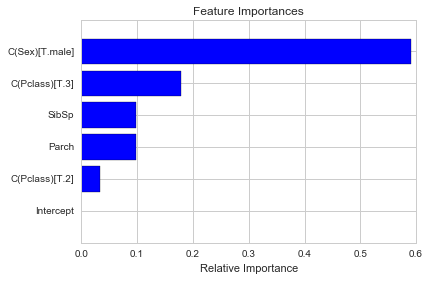

In [59]:
trained_random_forest = make_experiment(formula, clf=random_forest, train_data=train_df)

In [60]:
test_df[['Pclass', 'Sex', 'SibSp', 'Parch']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
Pclass    418 non-null int64
Sex       418 non-null object
SibSp     418 non-null int64
Parch     418 non-null int64
dtypes: int64(3), object(1)
memory usage: 13.1+ KB


### 2.1.3 Prediction #1

In [61]:
predict(formula, iteration_number=1, clf=trained_random_forest, test_data=test_df)

After submitted this prediction I was scored with 0.76555, seems very close to model evaluation so I will use cross validation in my future iterations.

## 2.2 Iteration #2

### 2.2.1 Preparation

Let's take a look at the Age variable as intuitevly it can make prediction more concise. 

In [62]:
# combine train and test datasets into one to ipmute missing values
titanic_df = train_df.append(test_df, ignore_index=True).copy()

In [63]:
# Show number of missing Age values
titanic_df["Age"].isnull().sum()

263

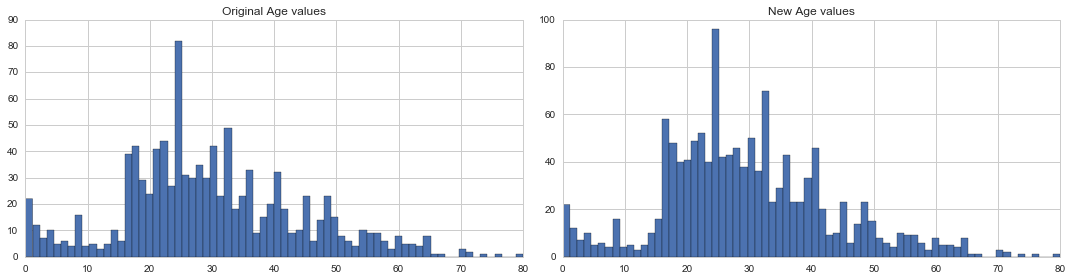

In [64]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

axis1.set_title('Original Age values')
axis2.set_title('New Age values')

# plot original Age values
# NOTE: drop all null values, and convert to int
titanic_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

# get average, std, and number of NaN values
average_age = titanic_df["Age"].mean()
std_age = titanic_df["Age"].std()
count_nan_age = titanic_df["Age"].isnull().sum()

# generate random numbers between (mean - std) & (mean + std)
rand_age = np.random.randint(average_age - std_age, average_age + std_age, size = count_nan_age)

# fill NaN values in Age column with random values generated
age_hypothese = titanic_df["Age"].copy()

age_hypothese[np.isnan(age_hypothese)] = rand_age

# plot imputed Age values
age_hypothese.astype(int).hist(bins=70, ax=axis2)

plt.tight_layout()

Things look good, so let’s replace our Age vector in the original data with the new values

In [65]:
titanic_df["Age"] = age_hypothese

In [66]:
# Show number of missing Age values
titanic_df["Age"].isnull().sum()

0

In [67]:
# Split data back into train dataframe
train_df = titanic_df[:891]; train_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
Pclass    891 non-null int64
Sex       891 non-null object
Age       891 non-null float64
SibSp     891 non-null int64
Parch     891 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 34.9+ KB


### 2.2.2 Experiment

Score on training data: 0.916947250281
Accuracy: 0.778 (+/- 0.013)


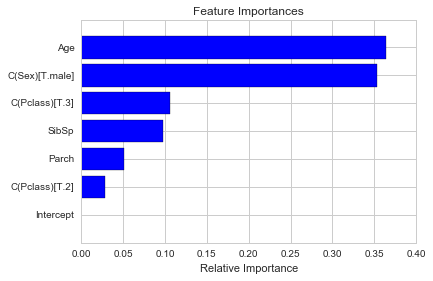

In [68]:
formula = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch' 

trained_random_forest = make_experiment(formula, clf=random_forest, train_data=train_df)

This is not better than first iteration so let's go forward, to the next iteration.

## 2.3 Iteration #3

It seems that adding new variable Age with much imputed values does not help. Let's try to reduce number of sets, remove NaN values and keep only original data.

### 2.3.1 Preparation

In [69]:
# Make a copy of the titanic data frame
titanic_df['Title'] = titanic_df['Name']

# Grab title from passenger names
titanic_df["Title"].replace(to_replace='(.*, )|(\\..*)', value='', inplace=True, regex=True)

In [70]:
# Titles with very low cell counts to be combined to "rare" level
rare_titles = ['Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']
titanic_df['Title'].replace(rare_titles, "Rare title", inplace=True)

# Also reassign mlle, ms, and mme accordingly
titanic_df['Title'].replace(["Mlle","Ms", "Mme"], ["Miss", "Miss", "Mrs"], inplace=True)

In [71]:
# Split data back into train and test dataframes
train_df = titanic_df[:891]; train_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Title']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
Pclass    891 non-null int64
Sex       891 non-null object
Age       891 non-null float64
SibSp     891 non-null int64
Parch     891 non-null int64
Title     891 non-null object
dtypes: float64(1), int64(3), object(2)
memory usage: 41.8+ KB


### 2.3.2 Experiment

Score on training data: 0.92480359147
Accuracy: 0.780 (+/- 0.008)


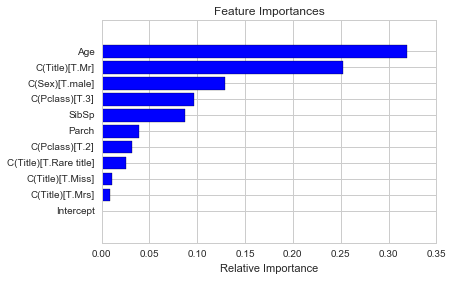

In [72]:
formula = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + C(Title)' 

trained_random_forest = make_experiment(formula, clf=random_forest, train_data=train_df)

## 2.4 Iteration #4

### 2.4.1 Preparation

In [73]:
# Create a family size variable including the passenger themselves
titanic_df["Fsize"] = titanic_df.SibSp + titanic_df.Parch + 1

# Discretize family size
titanic_df.ix[titanic_df.Fsize > 4, "Fsize"] = "large"
titanic_df.ix[titanic_df.Fsize == 1, "Fsize"] = 'singleton'
titanic_df.ix[(titanic_df.Fsize < 5) & (titanic_df.Fsize > 1), "Fsize"] = "small"

In [74]:
# Split data back into train and test dataframes
train_df = titanic_df[:891]; train_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Title', 'Fsize']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Pclass    891 non-null int64
Sex       891 non-null object
Age       891 non-null float64
SibSp     891 non-null int64
Parch     891 non-null int64
Title     891 non-null object
Fsize     891 non-null object
dtypes: float64(1), int64(3), object(3)
memory usage: 48.8+ KB


### 2.4.2 Experiment #4

Score on training data: 0.925925925926
Accuracy: 0.783 (+/- 0.003)


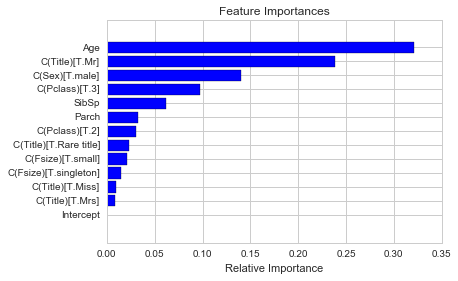

In [75]:
formula = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + C(Title) + C(Fsize)' 

trained_random_forest = make_experiment(formula, clf=random_forest, train_data=train_df)

### 2.4.3 Prediction #4

In [76]:
# Split data back into train and test dataframes
test_df = titanic_df[891:]; test_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Title', 'Fsize']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 891 to 1308
Data columns (total 7 columns):
Pclass    418 non-null int64
Sex       418 non-null object
Age       418 non-null float64
SibSp     418 non-null int64
Parch     418 non-null int64
Title     418 non-null object
Fsize     418 non-null object
dtypes: float64(1), int64(3), object(3)
memory usage: 22.9+ KB


In [77]:
predict(formula, iteration_number=4, clf=trained_random_forest, test_data=test_df)

## 2.5 Iteration #5

### 2.5.1 Preparation
Let's remove SibSp and Parch variables as they already included in Fsize feature and see the score and accuracy

### 2.5.2 Experiment

Score on training data: 0.913580246914
Accuracy: 0.780 (+/- 0.008)


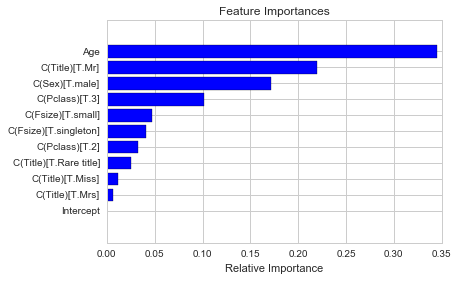

In [78]:
formula = 'Survived ~ C(Pclass) + C(Sex) + Age + C(Title) + C(Fsize)' 

trained_random_forest = make_experiment(formula, clf=random_forest, train_data=train_df)

Accuracy became slightly better so I guess we can remove this features from model.

## 2.6 Iteration #6 (add Fare feature)

### 2.6.1 Preparation

In [79]:
# Let's find passengers with missing Fare feature
np.where(titanic_df["Fare"].isnull())[0]

array([1043])

In [80]:
titanic_df.ix[[1043]]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Fsize
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,0.5,3701,Mr,singleton


This is a third class passenger who departed from Southampton (‘S’). Let’s visualize Fares among all others sharing their class and embarkment (n = 494).

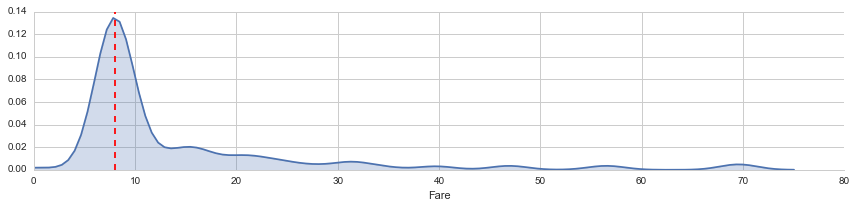

In [81]:
facet = sns.FacetGrid(titanic_df[(titanic_df['Pclass'] == 3) & (titanic_df['Embarked'] == 'S')], aspect=4)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, 80))

fare_median = titanic_df[(titanic_df['Pclass'] == 3) & (titanic_df['Embarked'] == 'S')]['Fare'].median()
plt.axvline(x=fare_median, color='r', ls='--')

From this visualization, it seems quite reasonable to replace the NA Fare value with median for their class and embarkment which is `$`8.05.

In [82]:
# Replace missing fare value with median fare for class/embarkment
titanic_df.loc[[1043],'Fare'] = fare_median

In [83]:
# Split data back into train and test dataframes
train_df = titanic_df[:891]; train_df[['Pclass', 'Sex', 'Age', 'Title', 'Fsize', 'Fare']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
Pclass    891 non-null int64
Sex       891 non-null object
Age       891 non-null float64
Title     891 non-null object
Fsize     891 non-null object
Fare      891 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 41.8+ KB


### 2.6.2 Experiment

Score on training data: 0.985409652076
Accuracy: 0.773 (+/- 0.053)


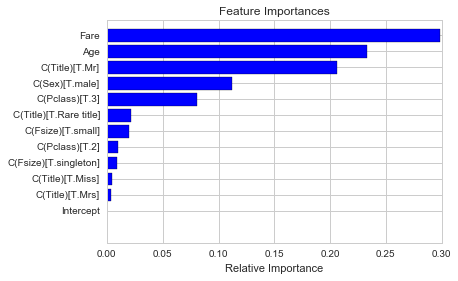

In [93]:
formula = 'Survived ~ C(Pclass) + C(Sex) + Age + C(Title) + C(Fsize) + Fare' 

trained_random_forest = make_experiment(formula, clf=random_forest, train_data=train_df)

### 2.6.3 Prediction #6

In [85]:
# Split data back into train and test dataframes
test_df = titanic_df[891:]; test_df[['Pclass', 'Sex', 'Age', 'Title', 'Fsize', 'Fare']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 891 to 1308
Data columns (total 6 columns):
Pclass    418 non-null int64
Sex       418 non-null object
Age       418 non-null float64
Title     418 non-null object
Fsize     418 non-null object
Fare      418 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 19.7+ KB


In [86]:
predict(formula, iteration_number=6, clf=trained_random_forest, test_data=test_df)

After this submission I was scored with 0.75120 what is not improvement of the first attempt. Keep going.

# 2. Feature engineering
## 2.1 What's in a name?

The first variable which catches my attention is **passenger name** because we can break it down into additional meaningful variables which can feed predictions or be used in the creation of additional new variables. For instance, **passenger title** is contained within the passenger name variable and we can use **surname** to represent families. Let’s do some **feature engineering**!

In [204]:
# Make a copy of the titanic data frame
titanic_df['Title'] = titanic_df['Name']

# Grab title from passenger names
titanic_df["Title"].replace(to_replace='(.*, )|(\\..*)', value='', inplace=True, regex=True)

In [205]:
titanic_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


In [206]:
# Show title counts by sex
titanic_df.groupby(["Sex", "Title"]).size().unstack(fill_value=0)

Title,Capt,Col,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Sex,,,,,,,,,,,,,,,,,,
female,0,0,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0,1
male,1,4,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1,0


In [207]:
# Titles with very low cell counts to be combined to "rare" level
rare_titles = ['Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']
titanic_df['Title'].replace(rare_titles, "Rare title", inplace=True)

# Also reassign mlle, ms, and mme accordingly
titanic_df['Title'].replace(["Mlle","Ms", "Mme"], ["Miss", "Miss", "Mrs"], inplace=True)

In [208]:
# Show title counts by sex
titanic_df.groupby(["Sex", "Title"]).size().unstack(fill_value=0)

Title,Master,Miss,Mr,Mrs,Rare title
Sex,,,,,
female,0,264,0,198,4
male,61,0,757,0,25


## 2.2 Do families sink or swim together?

Now that we’ve taken care of splitting passenger name into some new variables, we can take it a step further and make some new family variables. First we’re going to make a **family size** variable based on number of siblings/spouse(s) (maybe someone has more than one spouse?) and number of children/parents.

In [209]:
# Make a copy of the titanic data frame
family_df = titanic_df.loc[:,["Parch", "SibSp", "Survived"]]

# Create a family size variable including the passenger themselves
family_df["Fsize"] = family_df.SibSp + family_df.Parch + 1

family_df.head()

,Parch,SibSp,Survived,Fsize
0,0,1,0.0,2
1,0,1,1.0,2
2,0,0,1.0,1
3,0,1,1.0,2
4,0,0,0.0,1


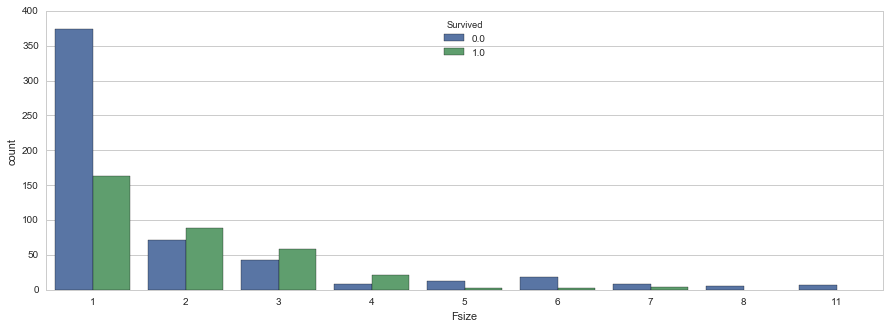

In [210]:
# make figure wider
plt.figure(figsize=(15,5))

# visualize the relationship between family size & survival
sns.countplot(x='Fsize', hue="Survived", data=family_df)

Ah hah. We can see that there’s a survival penalty to singletons and those with family sizes above 4. We can collapse this variable into three levels which will be helpful since there are comparatively fewer large families. Let’s create a **discretized family size** variable.

In [211]:
# Discretize family size
family_df.ix[family_df.Fsize > 4, "Fsize"] = "large"
family_df.ix[family_df.Fsize == 1, "Fsize"] = 'singleton'
family_df.ix[(family_df.Fsize < 5) & (family_df.Fsize > 1), "Fsize"] = "small"


family_df.head(10)

,Parch,SibSp,Survived,Fsize
0,0,1,0.0,small
1,0,1,1.0,small
2,0,0,1.0,singleton
3,0,1,1.0,small
4,0,0,0.0,singleton
5,0,0,0.0,singleton
6,0,0,0.0,singleton
7,1,3,0.0,large
8,2,0,1.0,small
9,0,1,1.0,small


(<matplotlib.figure.Figure at 0x7f0641ed28d0>,
 OrderedDict([(('small', '0.0'), (0.0, 0.0, 0.3244768921336578, 0.41983343193919809)), (('small', '1.0'), (0.0, 0.42315569107541073, 0.3244768921336578, 0.57684430892458916)), (('singleton', '0.0'), (0.3294273871831628, 0.0, 0.5967263393005967, 0.6941479982924702)), (('singleton', '1.0'), (0.3294273871831628, 0.69747025742868274, 0.5967263393005967, 0.30252974257131715)), (('large', '0.0'), (0.9311042215332644, 0.0, 0.06889577846673557, 0.83592326653091842)), (('large', '1.0'), (0.9311042215332644, 0.83924552566713095, 0.06889577846673557, 0.16075447433286888))]))

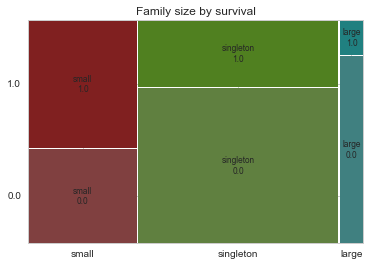

In [212]:
# Show family size by survival using a mosaic plot
mosaic(family_df, ['Fsize', 'Survived'], title="Family size by survival")

The mosaic plot shows that we preserve our rule that there’s a survival penalty among singletons and large families, but a benefit for passengers in small families. I want to do something further with our age variable, but 263 rows have missing age values, so we will have to wait until after we address missingness.

## 2.3 Treat a few more variables …

What’s left? There’s probably some potentially useful information in the **passenger cabin** variable including about their **deck**. Let’s take a look.

In [213]:
# This variable appears to have a lot of missing values
titanic_df["Cabin"].head(28)

0             NaN
1             C85
2             NaN
3            C123
4             NaN
5             NaN
6             E46
7             NaN
8             NaN
9             NaN
10             G6
11           C103
12            NaN
13            NaN
14            NaN
15            NaN
16            NaN
17            NaN
18            NaN
19            NaN
20            NaN
21            D56
22            NaN
23             A6
24            NaN
25            NaN
26            NaN
27    C23 C25 C27
Name: Cabin, dtype: object

In [214]:
# The first character is the deck. For example:
list(titanic_df["Cabin"][1])

['C', '8', '5']

In [215]:
# The number of not-null Cabin values
titanic_df["Cabin"].count()

295

There’s more that likely could be done here including looking into cabins with multiple rooms listed (e.g., row 28: “C23 C25 C27”), but given the sparseness of the column we’ll stop here.

# 3 Missingness

Now we’re ready to start exploring missing data and rectifying it through imputation. There are a number of different ways we could go about doing this. Given the small size of the dataset, we probably should not opt for deleting either entire observations (rows) or variables (columns) containing missing values. We’re left with the option of either replacing missing values with a sensible values given the distribution of the data, e.g., the mean, median or mode. Finally, we could go with prediction. We’ll use both of the two latter methods and I’ll rely on some data visualization to guide our decisions.

## 3.1 Sensible value imputation

In [216]:
# Let's find passengers with missing Embarked feature
np.where(titanic_df["Embarked"].isnull())[0]

array([ 61, 829])

In [217]:
titanic_df.ix[[61,829]]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Miss
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs


We will infer their values for embarkment based on present data that we can imagine may be relevant: **passenger class** and **fare**. We see that they paid **`$`80** and **`$`80** respectively and their classes are **1** and **1** . So from where did they embark?

In [218]:
# Get rid of our missing passenger IDs
embark_fare_df = titanic_df.drop([61,829], axis=0)

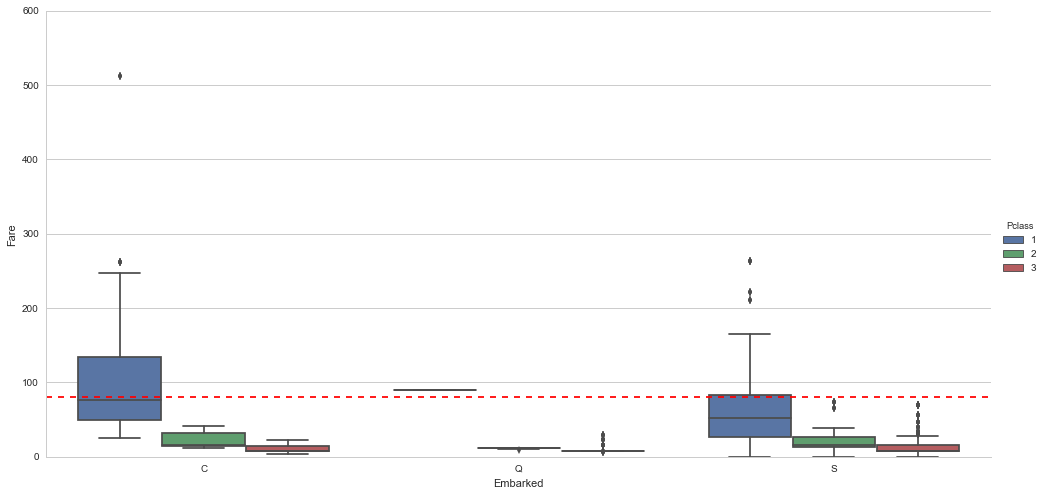

In [219]:
# Let's visualize embarkment, passenger class ...
sns.factorplot(x='Embarked',y='Fare', hue='Pclass', kind="box",order=['C', 'Q', 'S'],data=embark_fare_df, size=7,aspect=2)

# ... and median fare
plt.axhline(y=80, color='r', ls='--')

Voilà! The median fare for a first class passenger departing from Charbourg (‘C’) coincides nicely with the $80 paid by our embarkment-deficient passengers. I think we can safely replace the NA values with ‘C’.

In [220]:
# Since their fare was $80 for 1st class, they most likely embarked from 'C'
titanic_df.loc[[61,829],"Embarked"] = 'C'

We’re close to fixing the handful of NA values here and there. Passenger on row 1044 has an NA Fare value.

In [221]:
# Let's find passengers with missing Fare feature
np.where(titanic_df["Fare"].isnull())[0]

array([1043])

In [222]:
titanic_df.ix[[1043]]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,Mr


This is a third class passenger who departed from Southampton (‘S’). Let’s visualize Fares among all others sharing their class and embarkment (n = 494).

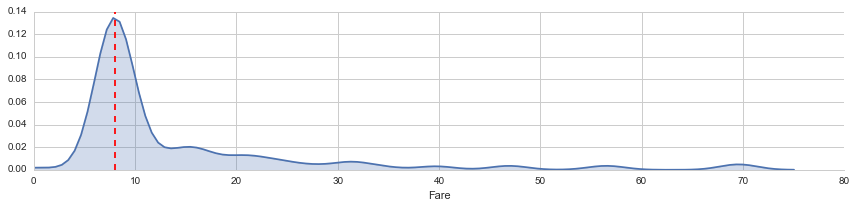

In [223]:
facet = sns.FacetGrid(titanic_df[(titanic_df['Pclass'] == 3) & (titanic_df['Embarked'] == 'S')], aspect=4)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, 80))

fare_median = titanic_df[(titanic_df['Pclass'] == 3) & (titanic_df['Embarked'] == 'S')]['Fare'].median()
plt.axvline(x=fare_median, color='r', ls='--')

From this visualization, it seems quite reasonable to replace the NA Fare value with median for their class and embarkment which is `$`8.05.

In [224]:
# Replace missing fare value with median fare for class/embarkment
titanic_df.loc[[1043],'Fare'] = fare_median

## 3.2 Predictive imputation

Finally, as we noted earlier, there are quite a few missing **Age** values in our data. We are going to get a bit more fancy in imputing missing age values. Why? Because we can. We will create a model predicting ages based on other variables.

In [225]:
# Show number of missing Age values
titanic_df["Age"].isnull().sum()

263

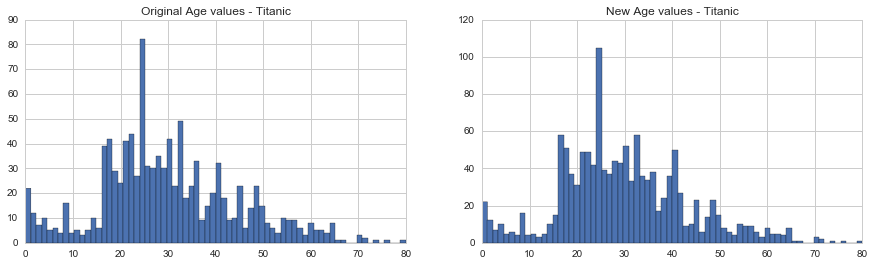

In [226]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Original Age values - Titanic')
axis2.set_title('New Age values - Titanic')

# plot original Age values
# NOTE: drop all null values, and convert to int
titanic_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

# get average, std, and number of NaN values
average_age = titanic_df["Age"].mean()
std_age = titanic_df["Age"].std()
count_nan_age = titanic_df["Age"].isnull().sum()

# generate random numbers between (mean - std) & (mean + std)
rand_age = np.random.randint(average_age - std_age, average_age + std_age, size = count_nan_age)

# fill NaN values in Age column with random values generated
age_slice = titanic_df["Age"].copy()
age_slice[np.isnan(age_slice)] = rand_age

# plot imputed Age values
age_slice.astype(int).hist(bins=70, ax=axis2)

Things look good, so let’s replace our Age vector in the original data with the new values

In [227]:
titanic_df["Age"] = age_slice

In [228]:
# Show number of missing Age values
titanic_df["Age"].isnull().sum()

0

We’ve finished imputing values for all variables that we care about for now! Now that we have a complete Age variable, there are just a few finishing touches I’d like to make. We can use Age to do just a bit more feature engineering …

## 3.3 Feature Engineering: Round 2

Now that we know everyone’s age, we can create a couple of new age-dependent variables: **Child** and **Mother**. A child will simply be someone under 18 years of age and a mother is a passenger who is:
* female
* is over 18
* has more than 0 children (no kidding!)
* does not have the title ‘Miss’.

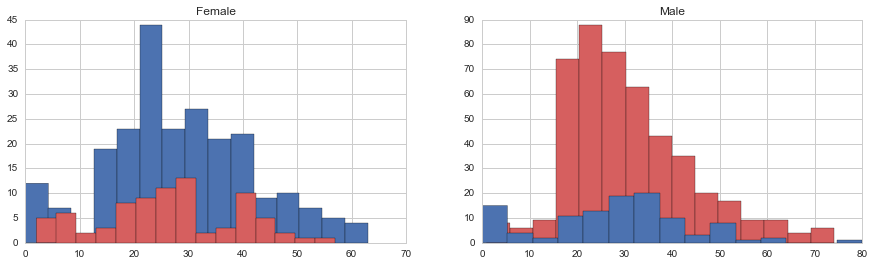

In [229]:
# peaks for survived/not survived passengers by their age
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Female')
axis2.set_title('Male')

titanic_df[(titanic_df['Sex'] == "female") & (titanic_df['Survived'] == 1)]['Age'].astype(int).hist(bins=15, ax=axis1, color="#4C72B0")
titanic_df[(titanic_df['Sex'] == "female") & (titanic_df['Survived'] == 0)]['Age'].astype(int).hist(bins=15, ax=axis1, color="#D65F5F")

titanic_df[(titanic_df['Sex'] == "male") & (titanic_df['Survived'] == 0)]['Age'].astype(int).hist(bins=15, ax=axis2, color="#D65F5F")
titanic_df[(titanic_df['Sex'] == "male") & (titanic_df['Survived'] == 1)]['Age'].astype(int).hist(bins=15, ax=axis2, color="#4C72B0")

# peaks for survived/not survived passengers by their age
#facet = sns.FacetGrid(titanic_df[titanic_df['Sex'] == "female"], hue="Survived",aspect=4)
#facet.map(sns.kdeplot,'Age',shade= True)
#facet.set(xlim=(0, titanic_df['Age'].max()))
#facet.add_legend()

#facet = sns.FacetGrid(titanic_df[titanic_df['Sex'] == "male"], hue="Survived",aspect=4)
#facet.map(sns.kdeplot,'Age',shade= True)
#facet.set(xlim=(0, titanic_df['Age'].max()))
#facet.add_legend()

In [230]:
# Create the column child, and indicate whether child or adult

def child_or_adult(age):
    return 'Child' if age < 16 else 'Adult'

titanic_df['Child'] = titanic_df['Age'].apply(child_or_adult)

In [231]:
# Show counts
titanic_df.groupby(["Child", "Survived"]).size().unstack()

Survived,0.0,1.0
Child,,
Adult,511,289
Child,38,53


Looks like being a child doesn’t hurt, but it’s not going to necessarily save you either! We will finish off our feature engineering by creating the **Mother** variable. Maybe we can hope that mothers are more likely to have survived on the Titanic.

In [232]:
# Adding Mother variable
titanic_df['Mother'] = 'Not Mother'

def choose_mother(person):
    sex, parch, age, title, mother = person
    return 'Mother' if (sex == 'female' and parch > 0 and age > 18 and title != 'Miss') else mother
       

titanic_df['Mother'] = titanic_df[['Sex', 'Parch', 'Age', 'Title', 'Mother']].apply(choose_mother, axis=1)

In [233]:
# Show counts
titanic_df.groupby(["Mother", "Survived"]).size().unstack()

Survived,0.0,1.0
Mother,,
Mother,16,39
Not Mother,533,303


All of the variables we care about should be taken care of and there should be no missing data. I’m going to double check just to be sure:

In [234]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
Age            1309 non-null float64
Cabin          295 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Title          1309 non-null object
Child          1309 non-null object
Mother         1309 non-null object
dtypes: float64(3), int64(4), object(8)
memory usage: 153.5+ KB


Wow! We have finally finished treating all of the relevant missing values in the Titanic dataset which has included some fancy imputation. We have also successfully created several new variables which we hope will help us build a model which reliably predicts survival.

# 4 Prediction

At last we’re ready to predict who survives among passengers of the Titanic based on variables that we carefully curated and treated for missing values. For this, we will rely on the **randomForest** classification algorithm; we spent all that time on imputation, after all.

## 4.1 Split into training & test sets

Our first step is to split the data back into the original test and training sets.

In [235]:
# Split the data back into a train set and a test set
train_df = titanic_df[0:890]
test_df = titanic_df[891:1309]

In [256]:
# define training and testing sets
X_train = train_df[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "Title", "Child", "Mother"]]
Y_train = train_df["Survived"]

X_test  = test_df[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "Title", "Child", "Mother"]]

In [258]:
enc = LabelEncoder()

X_train.Mother = enc.fit_transform(X_train.Mother)
X_train.Child = enc.fit_transform(X_train.Child)
X_train.Title = enc.fit_transform(X_train.Title)
X_train.Embarked = enc.fit_transform(X_train.Embarked)
X_train.Sex = enc.fit_transform(X_train.Sex)

In [259]:
random_forest = RandomForestClassifier(n_estimators=100)

random_forest.fit(X_train, Y_train)

random_forest.score(X_train, Y_train)

0.98202247191011238

In [260]:
# Predict
X_test.Mother = enc.fit_transform(X_test.Mother)
X_test.Child = enc.fit_transform(X_test.Child)
X_test.Title = enc.fit_transform(X_test.Title)
X_test.Embarked = enc.fit_transform(X_test.Embarked)
X_test.Sex = enc.fit_transform(X_test.Sex)

Y_pred = random_forest.predict(X_test)

In [261]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })

submission.to_csv('output/titanic.csv', index=False)